# XGBoost Regressor Model for S&P 500 Return Prediction

This notebook uses the combined S&P 500 dataset (2020-2025) to train an XGBoost Regressor model for predicting daily returns.

The model will predict the next day's return based on technical indicators (SMA, EMA, RSI).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, SMAIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date in chronological order (oldest to newest)
df = df.sort_index()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows (oldest dates):")
print(df.head())
print("\nLast few rows (newest dates):")
print(df.tail())

# Verify chronological order
print(f"\n✅ Data is sorted chronologically: {df.index.is_monotonic_increasing}")
print(f"Total trading days: {len(df)}")

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows (oldest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2020-01-02  3,244.67  3,258.14  3,235.53  3,257.85  1_01012020 to 12312020.csv
2020-01-03  3,226.36  3,246.15  3,222.34  3,234.85  1_01012020 to 12312020.csv
2020-01-06  3,217.55  3,246.84  3,214.64  3,246.28  1_01012020 to 12312020.csv
2020-01-07  3,241.86  3,244.91  3,232.43  3,237.18  1_01012020 to 12312020.csv
2020-01-08  3,238.59  3,267.07  3,236.67  3,253.05  1_01012020 to 12312020.csv

Last few rows (newest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2025-07-21  6,304.74  6,336.08  6,303.79  6,305.60  6_01012025 to 25072025.csv

In [3]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-01-02  3244.67  3258.14  3235.53  3257.85
2020-01-03  3226.36  3246.15  3222.34  3234.85
2020-01-06  3217.55  3246.84  3214.64  3246.28
2020-01-07  3241.86  3244.91  3232.43  3237.18
2020-01-08  3238.59  3267.07  3236.67  3253.05


In [4]:
# 3. Feature engineering
df["SMA_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["EMA_10"] = EMAIndicator(close=df["Close"], window=10).ema_indicator()
df["RSI"] = RSIIndicator(close=df["Close"], window=14).rsi()
df["Return"] = df["Close"].pct_change()
df["Target"] = df["Return"].shift(-1)  # Predict next day's return

print("Technical indicators created successfully!")
print(f"SMA_10 range: {df['SMA_10'].min():.2f} - {df['SMA_10'].max():.2f}")
print(f"RSI range: {df['RSI'].min():.2f} - {df['RSI'].max():.2f}")
print(f"Target (returns) range: {df['Target'].min():.6f} - {df['Target'].max():.6f}")

Technical indicators created successfully!
SMA_10 range: 2435.96 - 6309.63
RSI range: 18.11 - 82.90
Target (returns) range: -0.119841 - 0.095154


In [5]:
# 4. Drop rows with NaNs
df.dropna(inplace=True)
print(f"Dataset shape after cleaning: {df.shape}")
print(f"Remaining date range: {df.index.min()} to {df.index.max()}")

Dataset shape after cleaning: (1384, 10)
Remaining date range: 2020-01-22 00:00:00 to 2025-07-24 00:00:00


In [6]:
# 5. Prepare features and target
features = ["SMA_10", "EMA_10", "RSI"]
X = df[features]
y = df["Target"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics:")
print(X.describe())

Features shape: (1384, 3)
Target shape: (1384,)

Feature statistics:
            SMA_10       EMA_10          RSI
count  1384.000000  1384.000000  1384.000000
mean   4420.643259  4420.666018    55.214907
std     868.385065   867.439547    11.463011
min    2435.956000  2486.247281    18.106629
25%    3875.265000  3877.032887    46.672797
50%    4331.170500  4329.246308    56.979615
75%    5047.252000  5064.225869    63.979685
max    6296.740000  6302.954115    82.900322


In [7]:
# 6. Train/Test split (no shuffle for time series)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Test period: {y_test.index.min()} to {y_test.index.max()}")

Training set: 1284 samples
Test set: 100 samples
Test period: 2025-03-03 00:00:00 to 2025-07-24 00:00:00


In [8]:
# 7. Train the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("✅ Model training completed!")

✅ Model training completed!


In [9]:
# 8. Predict
y_pred = model.predict(X_test)
print(f"✅ Predictions completed!")
print(f"Predicted returns range: {y_pred.min():.6f} to {y_pred.max():.6f}")

✅ Predictions completed!
Predicted returns range: -0.010965 to 0.022846


In [10]:
# 9. Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== Model Performance ===")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test - y_pred)):.6f}")

# Additional insights
print(f"\n=== Additional Metrics ===")
print(f"Actual returns std: {y_test.std():.6f}")
print(f"Predicted returns std: {y_pred.std():.6f}")
print(f"Correlation: {np.corrcoef(y_test, y_pred)[0,1]:.4f}")

=== Model Performance ===
RMSE: 0.017554
R²: -0.1832
Mean Absolute Error: 0.010941

=== Additional Metrics ===
Actual returns std: 0.016219
Predicted returns std: 0.006400
Correlation: -0.0290


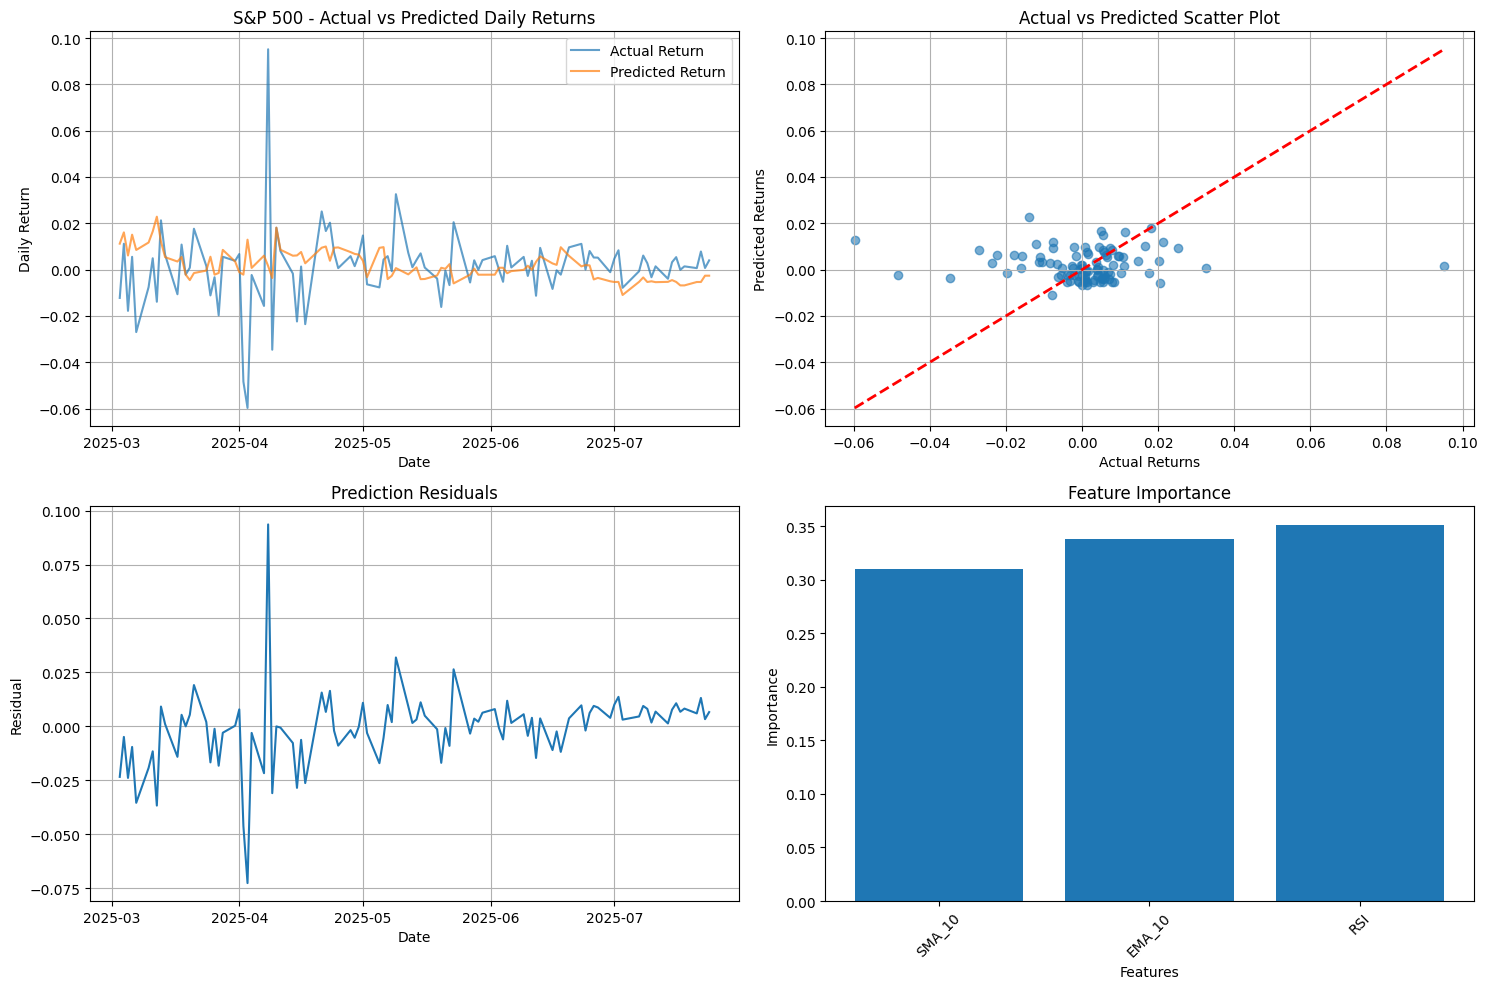

In [11]:
# 10. Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted Returns
plt.subplot(2, 2, 1)
plt.plot(y_test.index, y_test, label="Actual Return", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted Return", alpha=0.7)
plt.title("S&P 500 - Actual vs Predicted Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)

# Plot 2: Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Scatter Plot")
plt.grid(True)

# Plot 3: Residuals
plt.subplot(2, 2, 3)
residuals = y_test - y_pred
plt.plot(y_test.index, residuals)
plt.title("Prediction Residuals")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)

# Plot 4: Feature Importance
plt.subplot(2, 2, 4)
feature_importance = model.feature_importances_
plt.bar(features, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()